# Inference - Large

This file evaluates the machine learning model on the full MNIST test set.  

See the bottom for the code you need to accelerate.  


In [1]:
%matplotlib inline
import cProfile
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import truncnorm
import timeit

In [2]:
image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "./data/"

In [3]:
test_data = pd.read_csv(data_path + "mnist_test.csv", delimiter=",").values

fac = 0.99 / 255
test_imgs = np.asfarray(test_data[:, 1:], dtype=np.float32) * fac + 0.01
test_imgs = test_imgs.reshape(test_imgs.shape[0], 1, test_imgs.shape[1])

test_labels = np.asfarray(test_data[:, :1], dtype=np.float32)

lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
test_labels_one_hot = (lr==test_labels).astype(np.float32)

# we don't want zeroes and ones in the labels neither:
test_labels_one_hot[test_labels_one_hot==0] = 0.001
test_labels_one_hot[test_labels_one_hot==1] = 0.999

## Machine Learning Model

Based on: https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

All training (backward propagation) code removed

In [4]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # backward_propagation removed

In [5]:
# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size, dtype=np.float32) - 0.5
        self.bias = np.random.rand(1, output_size, dtype=np.float32) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # backward_propagation removed

In [6]:
# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # backward_propagation removed

In [7]:
class TanhLayer(ActivationLayer):
    # static
    e = 2.71828182845904523536028747135266249775724709369995
    
    #http://www.plunk.org/~hatch/rightway.php
    #https://math.stackexchange.com/questions/518758/alternative-form-for-sinhx-coshx
    @staticmethod
    def tanh(x):   
        e = TanhLayer.e
        return (1 - e ** (-2 * x)) / (1 + e ** (-2 * x)) 
        #return (1-np.exp(-2 * x))/(1+np.exp(-2 * x))

    @staticmethod
    def tanh_prime(x):
        return 1-TanhLayer.tanh(x)**2
    
    def __init__(self):
        super(TanhLayer,self).__init__(self.tanh, self.tanh_prime)

In [8]:
def mse(): pass
def mse_prime(): pass

In [9]:
class Network:
    def __init__(self):
        self.layers = []

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result
    
    # backward_propagation removed

    @classmethod
    def load(cls, fname):
        import pickle
        with open(fname, "br") as fh:
            return pickle.load(fh)

## Load the model

In [10]:
net = Network.load('network.pkl')

In [11]:
def evaluate(net, data, labels):
    corrects, wrongs = 0, 0
    for i in range(len(data)):
        res = np.array(net.predict(data[i]))
        res = res.argmax()
        if res == labels[i]:
            corrects += 1
        else:
            wrongs += 1
    return corrects, wrongs

# ============================
# This is the part you need to accelerate:
# ============================

In [12]:
start = timeit.default_timer()

# now with numpy's tanh!
corrects, wrongs = evaluate(net, test_imgs, test_labels)

stop = timeit.default_timer()

print ("Total Correct:" + str(corrects))
print ("Total Incorrect: " + str(wrongs))
print("Overall Accruracy: " + str(corrects / ( corrects + wrongs)))
print("Overall Accruracy (%): " + str( int( 1000* corrects / ( corrects + wrongs)) / 10) + "%")
print ()
print('Run Time: ' + str(stop - start) + ' Seconds')  

Total Correct:9565
Total Incorrect: 434
Overall Accruracy: 0.9565956595659566
Overall Accruracy (%): 95.6%

Run Time: 24.084029521007324 Seconds


# Tanh Lookup Table Work

In [13]:
# This layers redefines Tanh using Python's NumPy math functions
class TanhLayer(ActivationLayer):
        
    def __init__(self):
        super(NpTanhLayer,self).__init__(np.tanh, self.tanh_prime)
        
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_prime(x):        
        return 1-np.tanh(x)**2;     

Text(0,0.5,'Output')

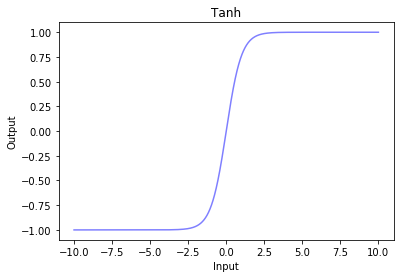

In [14]:
xs = np.linspace(-10, 10, num=10000)
ys = list(map( np.tanh, xs))

plt.plot(xs, ys, color='blue', alpha = 0.5)
plt.title("Tanh")
plt.xlabel("Input")
plt.ylabel("Output")

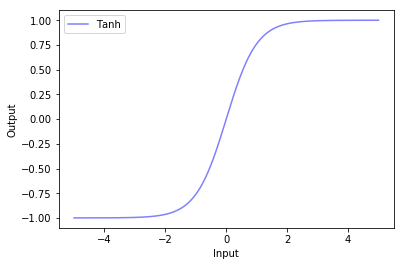

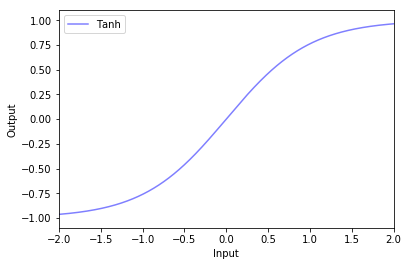

In [15]:
xs = np.linspace(-5, 5, num=10000)
ys = list(map( np.tanh, xs))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
plt.xlabel("Input")
plt.ylabel("Output")
ax.legend()
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-2,2])
ax.legend()
plt.show()

In [16]:
# stop at approximately +/- LUT_LIM
# We'll find the closest integer point to this value
LUT_LIM = 2
LUT_SIZE = 16 # 16 values in LUT
LUT_SCALE = LUT_SIZE / (LUT_LIM+LUT_LIM)
# integer steps
LUT_STEP = (1/LUT_SCALE)
LUT_XS = ( np.arange(-LUT_LIM, LUT_LIM, step=LUT_STEP) + 
            np.arange(LUT_LIM, -LUT_LIM, step=-LUT_STEP)[::-1] ) /2
LUT_YS = np.array( list((map( lambda x: 
                            np.tanh(x), 
                            LUT_XS))), dtype=np.float32)

def LUTtanh_1(x):
    if (x <= -LUT_LIM): return LUT_YS[0]
    elif (x >= LUT_LIM): return LUT_YS[-1]
    else: 
        idx = int( (x-(-LUT_LIM)) / (LUT_LIM-(-LUT_LIM)) * len(LUT_YS) )     
        return LUT_YS[idx]
    
LUT_SCALE = len(LUT_YS) / (LUT_LIM+LUT_LIM)
LUT_SHIFT = LUT_LIM * LUT_SCALE
def LUTtanh_2(x):
    if (x <= -LUT_LIM): return LUT_YS[0]
    elif (x >= LUT_LIM): return LUT_YS[-1]
    else: 
        idx = int( x*LUT_SCALE + LUT_SHIFT)      
        return LUT_YS[idx]
    
LUT_SCALE = int(len(LUT_YS) / (LUT_LIM+LUT_LIM))
LUT_SHIFT = int(int(LUT_LIM * LUT_SCALE))
def LUTtanh_3(x):
    idx = int(x*LUT_SCALE + LUT_SHIFT)
    if idx <=0: return LUT_YS[0]
    elif idx >=LUT_SIZE: return LUT_YS[-1]
    else: return LUT_YS[idx]    

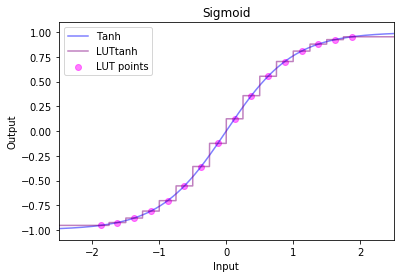

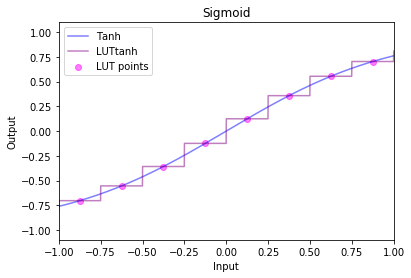

In [17]:
ys_lut = np.array(list(map( LUTtanh_3, xs)))


fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
ax.scatter(LUT_XS, LUT_YS, color='magenta', alpha = 0.5, label='LUT points')
ax.plot(xs, ys_lut, color='purple', alpha = 0.5, label='LUTtanh')
plt.title("Sigmoid")
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-2.5,2.5])
ax.legend()
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
ax.scatter(LUT_XS, LUT_YS, color='magenta', alpha = 0.5, label='LUT points')
ax.plot(xs, ys_lut, color='purple', alpha = 0.5, label='LUTtanh')
plt.title("Sigmoid")
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-1,1])
#plt.ylim([,1.1])
ax.legend()
plt.show()

In [18]:
# This layers redefines Tanh using a Lookup Table
class LutTanhLayer(ActivationLayer):
        
    def __init__(self):
        # stop at approximately +/- LUT_LIM
        # We'll find the closest integer point to this value
        LUT_LIM = 2
        LUT_SIZE = 64 # determined experimentally
        LUT_SCALE = LUT_SIZE / (LUT_LIM+LUT_LIM)
        # integer steps
        LUT_STEP = (1/LUT_SCALE)
        LUT_XS = ( np.arange(-LUT_LIM, LUT_LIM, step=LUT_STEP) + 
                    np.arange(LUT_LIM, -LUT_LIM, step=-LUT_STEP)[::-1] ) /2
        self.LUT_YS = np.array( list((map( lambda x: 
                                    np.tanh(x), 
                                    LUT_XS))), dtype=np.float32)

        self.LUT_SIZE = LUT_SIZE
        self.LUT_SCALE = LUT_SCALE
        self.LUT_SHIFT = int(LUT_LIM * LUT_SCALE)

        super(LutTanhLayer,self).__init__(np.vectorize(self.tanh), self.tanh_prime)
               
    def tanh(self,x):
        # Lookup Table Version
        #idx = int( np.floor(x*self.LUT_SCALE)) + self.LUT_SHIFT
        idx = int( x*self.LUT_SCALE + self.LUT_SHIFT )
        if idx <=0: return self.LUT_YS[0]
        elif idx >=self.LUT_SIZE: return self.LUT_YS[-1]
        else: return self.LUT_YS[idx]   
    
    @staticmethod
    def tanh_prime(x):        
        return 1-np.tanh(x)**2; 

In [19]:
net2 = Network.load('network.pkl')

for i in range(len(net2.layers)):
    l = net2.layers[i]
    is_tanh = isinstance(l, TanhLayer)
    print ("Index: " + str(i))
    print ("Layer Name: " + str(l.__class__.__name__))
    print ("Layer is Tanh: " + str(is_tanh))
    if is_tanh:
        print ("Replacing Tanh with LutTanh")
        net2.layers[i] = LutTanhLayer()
    print ()

Index: 0
Layer Name: FCLayer
Layer is Tanh: False

Index: 1
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with LutTanh

Index: 2
Layer Name: FCLayer
Layer is Tanh: False

Index: 3
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with LutTanh

Index: 4
Layer Name: FCLayer
Layer is Tanh: False

Index: 5
Layer Name: TanhLayer
Layer is Tanh: True
Replacing Tanh with LutTanh

Index: 6
Layer Name: FCLayer
Layer is Tanh: False



In [20]:
# Looks like 64 entries gives us the correct accuracy

start = timeit.default_timer()

corrects, wrongs = evaluate(net2, test_imgs, test_labels)

stop = timeit.default_timer()

print ("Total Correct:" + str(corrects))
print ("Total Incorrect: " + str(wrongs))
print("Overall Accruracy: " + str(corrects / ( corrects + wrongs)))
print("Overall Accruracy (%): " + str( int( 1000* corrects / ( corrects + wrongs)) / 10) + "%")
print ()
print('Run Time: ' + str(stop - start) + ' Seconds') 

Total Correct:9562
Total Incorrect: 437
Overall Accruracy: 0.9562956295629563
Overall Accruracy (%): 95.6%

Run Time: 44.00545496898121 Seconds


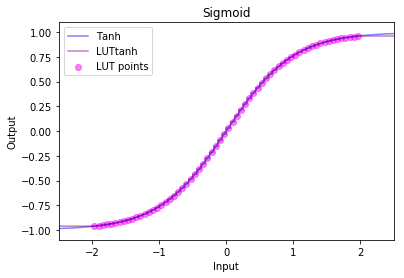

localparam [31:0] LUT_TABLE [0:63] = {
//x:-1.968750000, -1.906250000, -1.843750000, -1.781250000, -1.718750000, -1.656250000
//y:-0.961751938, -0.956769347, -0.951153815, -0.944829464, -0.937712312, -0.929710329
    32'hbf763560, 32'hbf74eed6, 32'hbf737ed1, 32'hbf71e058, 32'hbf700dea, 32'hbf6e017f,
//x:-1.593750000, -1.531250000, -1.468750000, -1.406250000, -1.343750000, -1.281250000
//y:-0.920722306, -0.910638273, -0.899338722, -0.886695147, -0.872570038, -0.856817603
    32'hbf6bb475, 32'hbf691f97, 32'hbf663b10, 32'hbf62fe74, 32'hbf5f60c0, 32'hbf5b5866,
//x:-1.218750000, -1.156250000, -1.093750000, -1.031250000, -0.968750000, -0.906250000
//y:-0.839285076, -0.819814026, -0.798242748, -0.774409175, -0.748154461, -0.719327509
    32'hbf56db63, 32'hbf51df55, 32'hbf4c59a3, 32'hbf463fae, 32'hbf3f870d, 32'hbf3825d9,
//x:-0.843750000, -0.781250000, -0.718750000, -0.656250000, -0.593750000, -0.531250000
//y:-0.687790215, -0.653423607, -0.616134405, -0.575862408, -0.532587290, -0.486336023
 

In [31]:
import numpy as np
LUT_LIM = 2 # seems to be flattened
LUT_SIZE = 64 # 64 yields 95.6% accuracy
LUT_SCALE = LUT_SIZE / (LUT_LIM+LUT_LIM)
LUT_STEP = (LUT_LIM+LUT_LIM)/LUT_SIZE
LUT_XS = ( np.arange(-LUT_LIM, LUT_LIM, step=LUT_STEP) + 
            np.arange(LUT_LIM, -LUT_LIM, step=-LUT_STEP)[::-1] ) /2
LUT_YS = np.array( list((map( lambda x: 
                            np.tanh(x), 
                            LUT_XS))), dtype=np.float32)

LUT_SHIFT = int(LUT_LIM / LUT_STEP)
def LUTtanh(x):
    idx = int(x*LUT_SCALE + LUT_SHIFT)
    if idx <=0: return LUT_YS[0]
    elif idx >=LUT_SIZE: return LUT_YS[-1]
    else: return LUT_YS[idx]
    
xs = np.linspace(-5, 5, num=10000)
ys = list(map( np.tanh, xs))
ys_lut = np.array(list(map( LUTtanh, xs)))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
ax.scatter(LUT_XS, LUT_YS, color='magenta', alpha = 0.5, label='LUT points')
ax.plot(xs, ys_lut, color='purple', alpha = 0.5, label='LUTtanh')
plt.title("Tanh")
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-2.5,2.5])
ax.legend()
plt.show()

import struct
def flt_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])
flts_hex = list(map(lambda x: '32\'h' + flt_to_hex(x)[2:], LUT_YS))
xs_str = list(map('{:+2.9f}'.format, LUT_XS))
ys_str = list(map('{:+2.9f}'.format, LUT_YS))
print ('localparam [31:0] LUT_TABLE [0:' + str(len(flts_hex)-1) + '] = {')
for i in range(0, len(flts_hex), 6):
    print ('//x:' + ', '.join(xs_str[i:i+6]))
    print ('//y:' + ', '.join(ys_str[i:i+6]))
    print ('    ' + ', '.join(flts_hex[i:i+6] ), end='')
    print (',' if i < len(flts_hex) - 6 else ' ')
print ('};') 
print ('localparam LUT_TABLE_SIZE = ' + str(len(flts_hex)) + ';')
# assumes input in signed 32'hXXXX.XXXX fixed point format
X_SHIFT = int(LUT_LIM * (2<<15))
X_MAX = int( (2*LUT_LIM) * (2<<15))
print ('localparam X_SHIFT = 32\'h' + hex(X_SHIFT)[2:] + '; // ' + str(LUT_LIM))
print ('localparam X_MAX = 32\'h' + hex(X_MAX)[2:] + '; // ' + str(2 *LUT_LIM))

In [22]:
import struct
def flt_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])
flts = [-16, -4.0, -2.1, -1.2, 0, 1.2, 4.0, 32.999]
flts_hex = list(map(lambda x: '32\'h' + flt_to_hex(x)[2:], flts))
flts_str = list(map('"{:2.4f}"'.format, flts))
offset=6
print ('static bit [31:0] fpHex [0:' + str(len(flts)-1) + '] = {')
for i in range(0, len(flts), offset):
    print (' ' + ', '.join(flts_hex[i:i+offset] ), end='')
    print (',' if i < len(flts) - offset else ' ')
print ('};') 
print ('static string fpAscii [0:' + str(len(flts)-1) + '] = {')
for i in range(0, len(flts), offset):
    print (' ' + ', '.join(flts_str[i:i+offset]), end='')
    print (',' if i < len(flts) - offset else ' ')
print ('};')

static bit [31:0] fpHex [0:7] = {
 32'hc1800000, 32'hc0800000, 32'hc0066666, 32'hbf99999a, 32'h0, 32'h3f99999a,
 32'h40800000, 32'h4203fefa 
};
static string fpAscii [0:7] = {
 "-16.0000", "-4.0000", "-2.1000", "-1.2000", "0.0000", "1.2000",
 "4.0000", "32.9990" 
};


In [32]:
import numpy as np
import struct
LUT_LIM = 2 # seems to be flattened
LUT_SIZE = 64 # 64 yields 95.6% accuracy
LUT_SCALE = LUT_SIZE / (LUT_LIM+LUT_LIM)
LUT_STEP = (1/LUT_SCALE)
LUT_XS = ( np.arange(-LUT_LIM, LUT_LIM, step=LUT_STEP) + 
            np.arange(LUT_LIM, -LUT_LIM, step=-LUT_STEP)[::-1] ) /2
LUT_YS = np.array( list((map( lambda x: 
                            np.tanh(x), 
                            LUT_XS))), dtype=np.float32)
X_SHIFT = int(LUT_LIM * (2<<15))
X_MAX = int( 2*LUT_LIM * (2<<15)) 

def vlog_lut(x):
    x_int = int(x * (2<<15)) & (2**32-1)
    x_scaled = (x_int + X_SHIFT) & (2**32-1)
    lut_idx = x_scaled >> 12
    if (lut_idx & X_MAX): return LUT_YS[0]
    elif (lut_idx >= LUT_SIZE): return LUT_YS[-1]
    else:  return LUT_YS[lut_idx] 
    
def flt_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])    
flts = [-16, -4.0, -2.1, -1.2, 0, 1.2, 4.0, 32.999]
flts = list(map(vlog_lut,flts))
flts_hex = list(map(lambda x: '32\'h' + flt_to_hex(x)[2:], flts))
flts_str = list(map('"{:2.4f}"'.format, flts))
offset=6
print ('static bit [31:0] fpHex [0:' + str(len(flts)-1) + '] = {')
for i in range(0, len(flts), offset):
    print (' ' + ', '.join(flts_hex[i:i+offset] ), end='')
    print (',' if i < len(flts) - offset else ' ')
print ('};') 
print ('static string fpAscii [0:' + str(len(flts)-1) + '] = {')
for i in range(0, len(flts), offset):
    print (' ' + ', '.join(flts_str[i:i+offset]), end='')
    print (',' if i < len(flts) - offset else ' ')
print ('};')

static bit [31:0] fpHex [0:7] = {
 32'hbf763560, 32'hbf763560, 32'hbf763560, 32'hbf56db63, 32'h3cffeaad, 32'h3f56db63,
 32'h3f763560, 32'h3f763560 
};
static string fpAscii [0:7] = {
 "-0.9618", "-0.9618", "-0.9618", "-0.8393", "0.0312", "0.8393",
 "0.9618", "0.9618" 
};


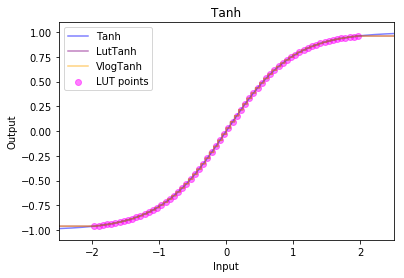

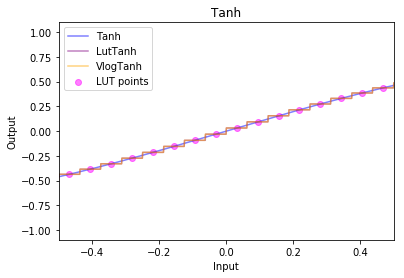

In [27]:
import numpy as np
import struct
LUT_LIM = 2 # seems to be flattened
LUT_SIZE = 64 # 64 yields 95.6% accuracy
LUT_SCALE = LUT_SIZE / (LUT_LIM+LUT_LIM)
LUT_STEP = (1/LUT_SCALE)
LUT_XS = ( np.arange(-LUT_LIM, LUT_LIM, step=LUT_STEP) + 
            np.arange(LUT_LIM, -LUT_LIM, step=-LUT_STEP)[::-1] ) /2
LUT_YS = np.array( list((map( lambda x: 
                            np.tanh(x), 
                            LUT_XS))), dtype=np.float32)
LUT_SHIFT = int(LUT_LIM / LUT_STEP)
def LUTtanh(x):
    idx = int(x*LUT_SCALE + LUT_SHIFT)
    if idx <=0: return LUT_YS[0]
    elif idx >=LUT_SIZE: return LUT_YS[-1]
    else: return LUT_YS[idx]
    

X_SHIFT = int(LUT_LIM * (2<<15))
X_MAX = int( LUT_XS[-1] * (2<<15)) + X_SHIFT
def vlog_tanh(x):
    x_int = int(x * (2<<15)) & (2**32-1)
    x_scaled = (x_int + X_SHIFT) & (2**32-1)
    lut_idx = x_scaled >> 12
    if (lut_idx & X_MAX): return LUT_YS[0]
    elif (lut_idx >= LUT_SIZE): return LUT_YS[-1]
    else:  return LUT_YS[lut_idx] 

xs = np.linspace(-5, 5, num=10000)
ys = list(map( np.tanh, xs))
ys_fp = np.array(list(map( LUTtanh, xs)))  
ys_vlog = np.array(list(map( vlog_tanh, xs)))    


import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
ax.scatter(LUT_XS, LUT_YS, color='magenta', alpha = 0.5, label='LUT points')
ax.plot(xs, ys_fp, color='purple', alpha = 0.5, label='LutTanh')
ax.plot(xs, ys_vlog, color='orange', alpha = 0.5, label='VlogTanh')

plt.title("Tanh")
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-2.5,2.5])
ax.legend()
plt.show()

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(xs, ys, color='blue', alpha = 0.5, label='Tanh')
ax.scatter(LUT_XS, LUT_YS, color='magenta', alpha = 0.5, label='LUT points')
ax.plot(xs, ys_fp, color='purple', alpha = 0.5, label='LutTanh')
ax.plot(xs, ys_vlog, color='orange', alpha = 0.5, label='VlogTanh')
plt.title("Tanh")
plt.xlabel("Input")
plt.ylabel("Output")
plt.xlim([-0.5,0.5])
ax.legend()
plt.show()